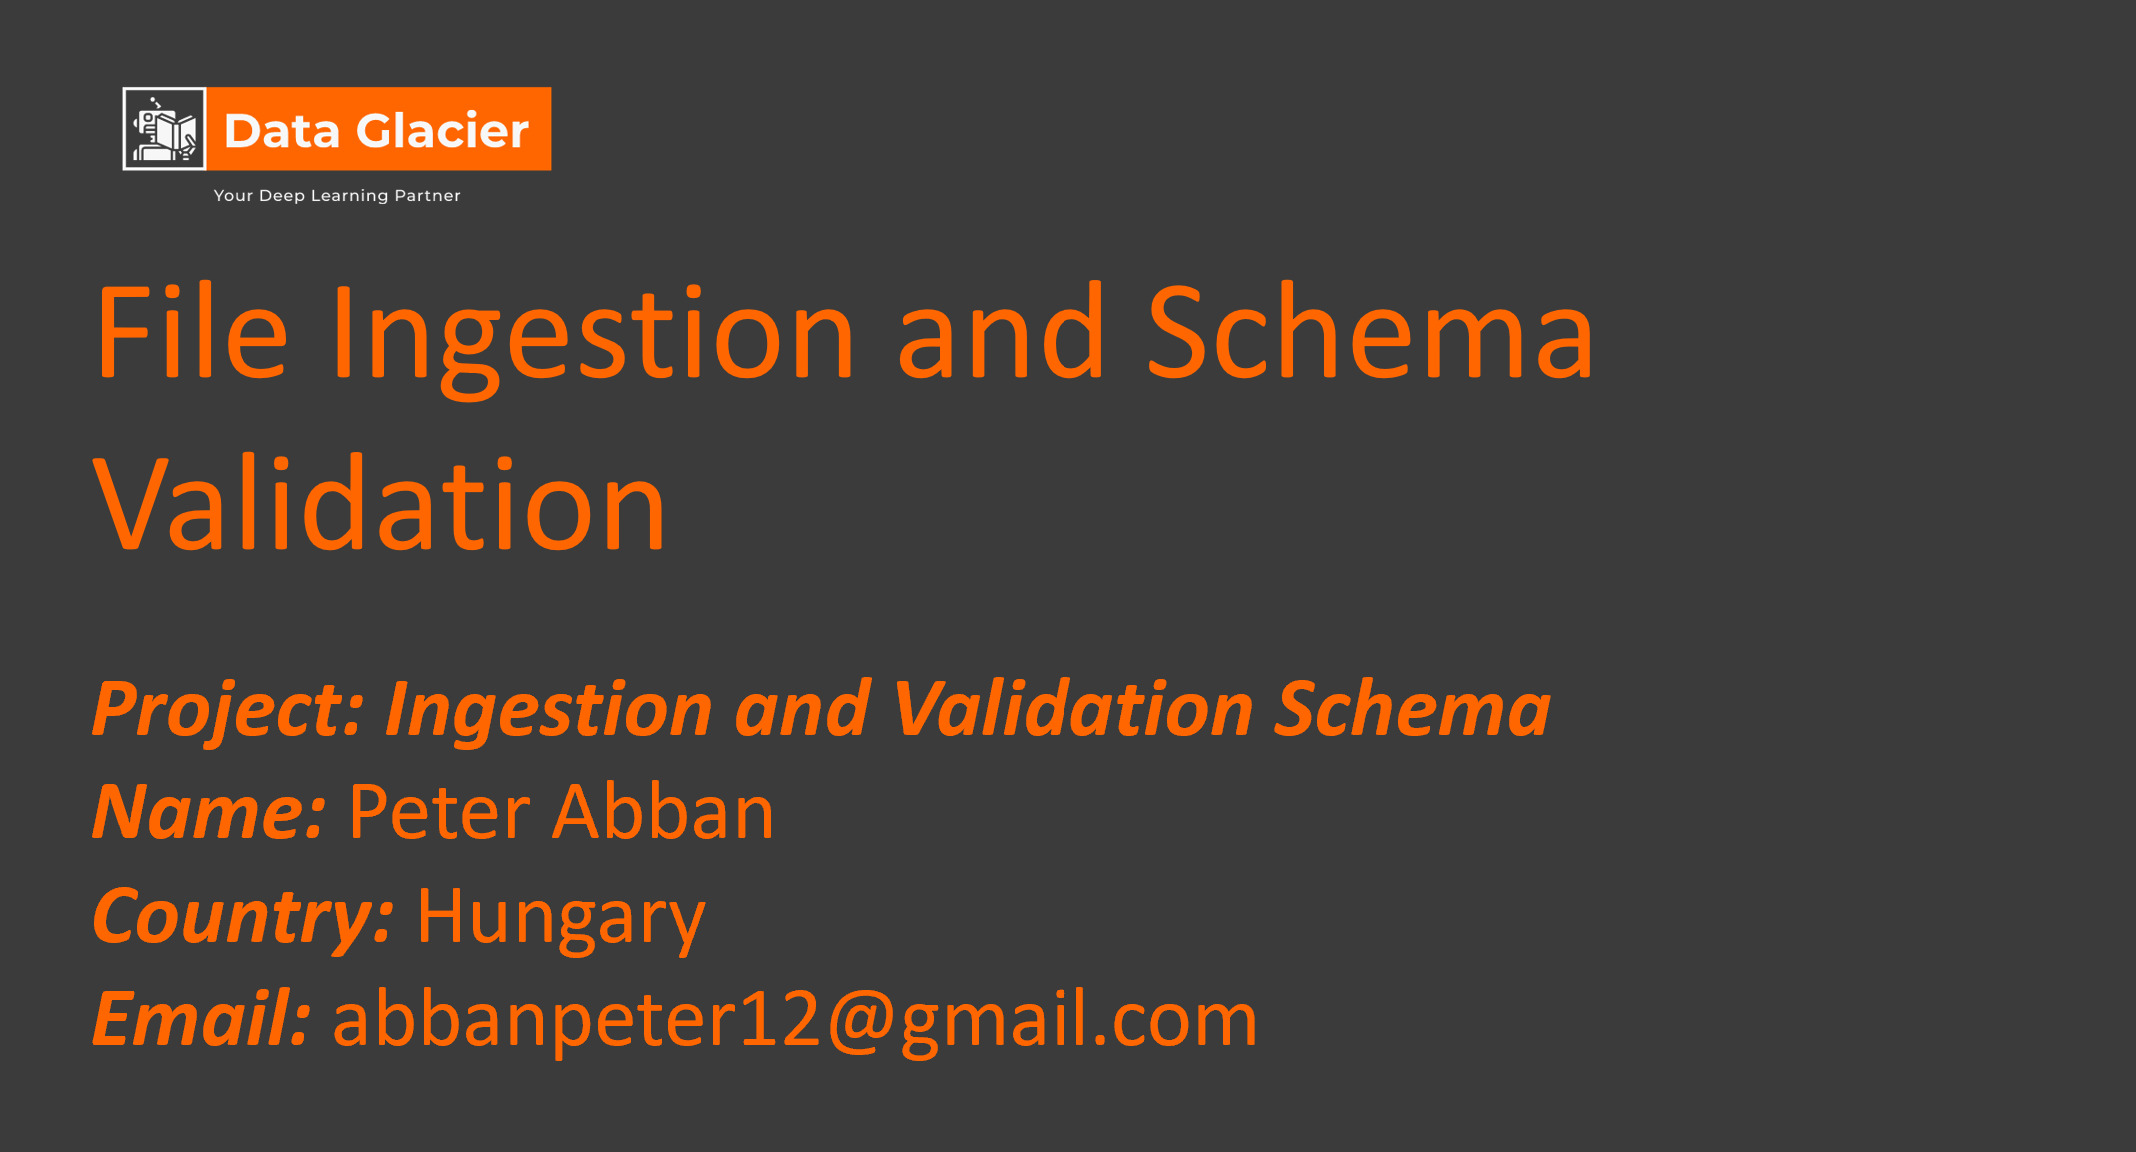

# **Task 1**: **Read a CSV file using pandas, Dask, Modin, and Ray, and compare               their computational efficiency.**

### **i. Reading with Pandas**:

In [102]:
import pandas as pd
df_pandas = pd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

### **ii. Reading with Ray**:


In [103]:
import ray
import ray.data as rd

ds_ray = rd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

### **iii. Reading with Dask**:

In [104]:
import dask.dataframe as dd
df_dask = dd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

## **iv. Reading with Modin**:


In [105]:
import modin.pandas as mpd
df_modin = mpd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

## **v. Measuring and Comparing Efficiency**:


In [106]:
print("Time taken to read with pandas:")
%time df_pandas = pd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

print("\nTime taken to read with Dask:")
%time df_dask = dd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

print("\nTime taken to read with Modin:")
%time df_modin = mpd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

print("\nTime taken to read with Ray:")
%time ds_ray = rd.read_csv("/U.S._Chronic_Disease_Indicators.csv")

Time taken to read with pandas:
CPU times: user 1.34 s, sys: 72.5 ms, total: 1.41 s
Wall time: 1.41 s

Time taken to read with Dask:
CPU times: user 7.18 ms, sys: 0 ns, total: 7.18 ms
Wall time: 7.15 ms

Time taken to read with Modin:
CPU times: user 68.8 ms, sys: 85.8 ms, total: 155 ms
Wall time: 2.17 s

Time taken to read with Ray:
CPU times: user 7.98 ms, sys: 2.61 ms, total: 10.6 ms
Wall time: 11.5 ms


### **_Observation_** :

* **Pandas** : Took the longest time in reading the file because it uses single-core processing

* **Dask** : Significantly faster than pandas due to its parallel computing ability and the possiblity to handle larger-than-memory datasets.

* **Modin**: Similarly showed a wall time comparable to pandas, however it had had a much lower CPU computation time. Modin speeds up the workflow of pandas by automatically distributing the computation across available cores using the backend support from Ray

* **Ray** :Fastest among the all the methods compared with a _total_ time of 12.4 ms.

#### **Summary** : _Ray_, and _Dask_ demonstrated better performance compared to _Pandas_ and _Modin_, more likely due to its ability to utilize multiple cores for reading the dataset. In addition, the faster reading methods will still demonstrate performance difference significantly higher even for larger dataset. _Ray_ and _Dask_ are much applicable and effective on large dataset where distribution is required for such dataset to loaded and preprocessed

# **Task 2 :** **Data Ingestion Pipeline and Validation Schema**

In [122]:
%%writefile utility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime
import gc
import re
################
# File Reading
################

def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

def validate_column_headers(df, target_headers):
    """
    Validates the column headers of a pandas DataFrame against a list of target headers.

    Args:
        df (pandas.DataFrame): The DataFrame to validate.
        target_headers (list): A list of target column headers.

    Returns:
        bool: True if the column headers match, False otherwise.
    """
    current_headers = df.columns.tolist()

    if current_headers == target_headers:
        print("Column headers match the target headers.")
        return True
    else:
        print("Column headers do NOT match the target headers.")
        print("Current Headers:", current_headers)
        print("Target Headers:", target_headers)

        missing_headers = set(target_headers) - set(current_headers)
        if missing_headers:
            print("\nMissing Headers:", missing_headers)

        extra_headers = set(current_headers) - set(target_headers)
        if extra_headers:
            print("Extra Headers:", extra_headers)

        return False

def summarize_Dataframe(df, file_path):
    """
    Summarizes a pandas DataFrame by providing the number of rows, columns, file size,
    data types, missing values, and basic descriptive statistics.

    Args:
        df (pandas.DataFrame): The DataFrame to summarize.
        file_path (str): The path to the original file from which the DataFrame was loaded.
    """
    print("--- DataFrame Summary ---")
    print(f"Total number of rows: {df.shape[0]}")
    print(f"Total number of columns: {df.shape[1]}")

    try:
        file_size = os.path.getsize(file_path)
        print(f"File size: {file_size} bytes")
    except FileNotFoundError:
        print(f"Could not determine file size: File not found at {file_path}")

    print("\n--- Data Types ---")
    print(df.dtypes)

    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    print("\n--- Descriptive Statistics (Numerical Columns) ---")
    try:
        display(df.describe())
    except Exception as e:
        print(f"Could not generate descriptive statistics: {e}")

    print("\n--- First 5 Rows ---")
    try:
        display(df.head())
    except Exception as e:
        print(f"Could not display head: {e}")

Overwriting utility.py


In [108]:
%%writefile file.yaml
file_type: csv
dataset_name: U.S._Chronic_Disease_Indicators
file_name: U.S._Chronic_Disease_Indicators
table_name: edsurv
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns:
    - YearStart
    - YearEnd
    - LocationAbbr
    - LocationDesc
    - DataSource
    - Topic
    - Question
    - Response
    - DataValueUnit
    - DataValueType
    - DataValue
    - DataValueAlt
    - DataValueFootnoteSymbol
    - DataValueFootnote
    - LowConfidenceLimit
    - HighConfidenceLimit
    - StratificationCategory1
    - Stratification1
    - StratificationCategory2
    - Stratification2
    - StratificationCategory3
    - Stratification3
    - Geolocation
    - LocationID
    - TopicID
    - QuestionID
    - ResponseID
    - DataValueTypeID
    - StratificationCategoryID1
    - StratificationID1
    - StratificationCategoryID2
    - StratificationID2
    - StratificationCategoryID3
    - StratificationID3



Overwriting file.yaml


In [124]:

import utility as util
import importlib
importlib.reload(util)

<module 'utility' from '/content/utility.py'>

In [110]:
# Reading config_file
config_data = util.read_config_file("file.yaml")

In [111]:
# Reading file type:
config_data['file_type']

'csv'

In [112]:
# Inspecting all information about data in the config_data:
config_data

{'file_type': 'csv',
 'dataset_name': 'U.S._Chronic_Disease_Indicators',
 'file_name': 'U.S._Chronic_Disease_Indicators',
 'table_name': 'edsurv',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'columns': ['YearStart',
  'YearEnd',
  'LocationAbbr',
  'LocationDesc',
  'DataSource',
  'Topic',
  'Question',
  'Response',
  'DataValueUnit',
  'DataValueType',
  'DataValue',
  'DataValueAlt',
  'DataValueFootnoteSymbol',
  'DataValueFootnote',
  'LowConfidenceLimit',
  'HighConfidenceLimit',
  'StratificationCategory1',
  'Stratification1',
  'StratificationCategory2',
  'Stratification2',
  'StratificationCategory3',
  'Stratification3',
  'Geolocation',
  'LocationID',
  'TopicID',
  'QuestionID',
  'ResponseID',
  'DataValueTypeID',
  'StratificationCategoryID1',
  'StratificationID1',
  'StratificationCategoryID2',
  'StratificationID2',
  'StratificationCategoryID3',
  'StratificationID3']}

In [129]:
# Read the file with config_data file:
file_type = config_data['file_type']
source_file = "/" + config_data['file_name'] + f'.{file_type}'

df_pandas = pd.read_csv(source_file, sep=config_data['inbound_delimiter'])


In [114]:
# Validation of the column headers:
if util.validate_column_headers(df_pandas, config_data['columns']):
    print("Columns validation passed")
else:
    print("Columns validation failed")

Column headers match the target headers.
Columns validation passed


In [115]:
### Print Final columns of Dataframe and YAML file
print("Final columns of the file")
print(df_pandas.columns)
print("\n\n")
print("YAML file columns")
print(config_data['columns'])

Final columns of the file
Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'Response', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DataValueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 'StratificationCategory2',
       'Stratification2', 'StratificationCategory3', 'Stratification3',
       'Geolocation', 'LocationID', 'TopicID', 'QuestionID', 'ResponseID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1',
       'StratificationCategoryID2', 'StratificationID2',
       'StratificationCategoryID3', 'StratificationID3'],
      dtype='object')



YAML file columns
['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource', 'Topic', 'Question', 'Response', 'DataValueUnit', 'DataValueType', 'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol', 'DataValueFootnote', 'LowConfide

In [117]:
# Define the output file path
output_file = "Final_Data.txt.gz"

# Write the DataFrame to a pipe-separated text file compressed with gzip
df_pandas.to_csv(output_file, sep='|', index=False, compression='gzip')

print(f"DataFrame successfully written to {output_file}")

DataFrame successfully written to Final_Data.txt.gz


In [127]:
# Define the path to the output file
input_file = "Final_Data.txt.gz"

# Read the pipe-separated, gzip-compressed text file into a pandas DataFrame
df_read = pd.read_csv(input_file, sep='|')

# Display the first few rows of the read DataFrame
display(df_read.head())

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2020,2020,US,United States,BRFSS,Health Status,Recent activity limitation among adults,NaN,Number,Age-adjusted Mean,...,HEA,HEA04,NaN,AGEADJMEAN,SEX,SEXF,NaN,NaN,NaN,NaN
1,2015,2019,AR,Arkansas,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,SEX,SEXM,NaN,NaN,NaN,NaN
2,2015,2019,CA,California,US Cancer DVT,Cancer,"Cervical cancer mortality among all females, u...",NaN,Number,Number,...,CAN,CAN03,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2015,2019,CO,Colorado,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2015,2019,GA,Georgia,US Cancer DVT,Cancer,"Prostate cancer mortality among all males, und...",NaN,Number,Number,...,CAN,CAN05,NaN,NMBR,RACE,WHT,NaN,NaN,NaN,NaN


In [128]:
# Display the summary of the dataframe
util.summarize_Dataframe(df_pandas, source_file)

--- DataFrame Summary ---
Total number of rows: 309215
Total number of columns: 34
File size: 88174053 bytes

--- Data Types ---
YearStart                      int64
YearEnd                        int64
LocationAbbr                  object
LocationDesc                  object
DataSource                    object
Topic                         object
Question                      object
Response                     float64
DataValueUnit                 object
DataValueType                 object
DataValue                    float64
DataValueAlt                 float64
DataValueFootnoteSymbol       object
DataValueFootnote             object
LowConfidenceLimit           float64
HighConfidenceLimit          float64
StratificationCategory1       object
Stratification1               object
StratificationCategory2      float64
Stratification2              float64
StratificationCategory3      float64
Stratification3              float64
Geolocation                   object
LocationID          

,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
count,309215.000000,309215.000000,0.0,2.091960e+05,2.091960e+05,188885.000000,188890.000000,0.0,0.0,0.0,0.0,309215.000000,0.0,0.0,0.0,0.0,0.0
mean,2020.012195,2020.288540,NaN,6.943569e+02,7.356701e+02,36.825051,46.030554,NaN,NaN,NaN,NaN,31.208693,NaN,NaN,NaN,NaN,NaN
std,1.530835,1.068591,NaN,1.620341e+04,1.834715e+04,65.025590,69.995643,NaN,NaN,NaN,NaN,17.798773,NaN,NaN,NaN,NaN,NaN
min,2015.000000,2019.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,2019.000000,2019.000000,NaN,1.240000e+01,1.240000e+01,9.100000,14.000000,NaN,NaN,NaN,NaN,17.000000,NaN,NaN,NaN,NaN,NaN
50%,2020.000000,2020.000000,NaN,2.700000e+01,2.700000e+01,19.500000,29.200000,NaN,NaN,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,NaN
75%,2021.000000,2021.000000,NaN,5.780000e+01,5.780000e+01,40.300000,54.300000,NaN,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN
max,2022.000000,2022.000000,NaN,2.925456e+06,2.925456e+06,1427.000000,1485.900000,NaN,NaN,NaN,NaN,78.000000,NaN,NaN,NaN,NaN,NaN



--- First 5 Rows ---


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2020,2020,US,United States,BRFSS,Health Status,Recent activity limitation among adults,NaN,Number,Age-adjusted Mean,...,HEA,HEA04,NaN,AGEADJMEAN,SEX,SEXF,NaN,NaN,NaN,NaN
1,2015,2019,AR,Arkansas,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,SEX,SEXM,NaN,NaN,NaN,NaN
2,2015,2019,CA,California,US Cancer DVT,Cancer,"Cervical cancer mortality among all females, u...",NaN,Number,Number,...,CAN,CAN03,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2015,2019,CO,Colorado,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2015,2019,GA,Georgia,US Cancer DVT,Cancer,"Prostate cancer mortality among all males, und...",NaN,Number,Number,...,CAN,CAN05,NaN,NMBR,RACE,WHT,NaN,NaN,NaN,NaN
